# Market position indicators using CFTC COTR 

We examine the CFTC **Commitment of Traders Reports (COTR)** 
for futures and options to derive indicators of market position *among 
Asset/Money Managers*. Our generalized formulation permits treating 
asset classes which include: precious metals, US dollar, bonds, and equities. 
Indicators may be post-processed to obtain further clarity, 
for example, normalization and smoothing.

Detailed explantory notes regarding the raw data can be found here:
http://www.cftc.gov/MarketReports/CommitmentsofTraders/ExplanatoryNotes 
We shall disregard the Legacy format, and focus on the data after 13 June 2006. 
*Current data is released weekly on Fridays* (for accounting 
effective through Tuesday).

We note the absence of strong linear correlations 
among our asset class position indicators. 

Lastly, we compute a dataframe of normalized position indicators 
which is useful for comparative study across asset classes 
and the identification of overcrowded trades.

*Shortcut to this notebook:* https://git.io/cotr 
where **Appendix 1 gives an algorithmic summary in a few lines of code.**

Appendix 2 visualizes the chronological joint path of the positions indicators for 
bonds and equities by color heat map -- which could be useful for asset allocation.

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas
     
*CHANGE LOG*

    2016-01-23  Fix issue #2 by v4 and p6 updates.
                   Smooth metals by ema(). Use groupfun() to normalize.
                   Add Appendix 1 and 2.
    2015-08-31  Simply use fecon.py to generally access various modules.
    2015-08-25  Update tpl to v4.15.0812. Add silver COTR,
                   and the class of precious metals w4cotr_metals.
    2015-08-09  Change of variable names for clarity.
    2015-08-07  First version arising as test of the Quandl API.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.11
 ::  IPython 4.0.0
 ::  jupyter 1.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  Repository: fecon235 v4.15.1230 develop
 ::  Timestamp: 2016-01-25, 02:58:19 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## COTR example: Gold

To get an idea of what's contained in a Commitment of Traders Report, 
we first look at an example from the commodity futures market. 
Financial futures have a different format since the notion of a 
"Producer" is not entirely appropriate 
(though dealers may produce derivatives which may rely on the futures market). 

The latest data is downloaded via Quandl as a pandas dataframe. 
The relevant functions are found in the yi_quandl module.

In [3]:
#  First download latest GOLD reports:
cotr = cotr_get( f4xau )
#                ^ = 'GC' currently.

#  Show column labels and only the last report:
tail( cotr, 1 )

            Open Interest  Producer/Merchant/Processor/User Longs  \
Date                                                                
2016-01-12         551508                                   39420   

            Producer/Merchant/Processor/User Shorts  Swap Dealer Longs  \
Date                                                                     
2016-01-12                                    89684              47977   

            Swap Dealer Shorts  Swap Dealer Spreads  Money Manager Longs  \
Date                                                                       
2016-01-12               44972               118408                85795   

            Money Manager Shorts  Money Manager Spreads  \
Date                                                      
2016-01-12                 84893                  56205   

            Other Reportable Longs  Other Reportable Shorts  \
Date                                                          
2016-01-12                   75149  

### Notable points

- Number of longs = Number of shorts, by necessity -- and each side equals the *Open Interest*.
- Option positions are computed on a futures-equivalent basis using delta factors supplied by the exchanges.
- Generally non-directional traders (usually with hedged positions): Producer/User, Swap Dealer, and Dealer.
- Generally **directional traders**: *Money Manager* (commodities), Leveraged Funds and *Asset Manager* (financials). Leveraged Funds appear to take very choppy short-term positions, whereas Asset Manager will show a longer-term positional narrative.
- Non-directional trading by a Money Manager, Asset Manager, and Leveraged Funds is categorized separately under Spreads.
- "Non reportable" traders are small players trading contract sizes under CFTC reporting thresholds -- generally, noise traders categorized as **speculators**.
- **COTR is released weekly on Friday** (for accounting effective through Tuesday).

### Parsing out positions

To characterize *informed* market direction we focus on the directional traders 
who are trading in large size which must be reported to the CFTC. 

Note that their *Longs* do not necessarily equal their *Shorts*" since the 
counter-parties may be other players in the market, 
e.g. hedged producers, spreaders, or small uninformed traders.

In [4]:
longs  = cotr['Money Manager Longs']
shorts = cotr['Money Manager Shorts']

In [5]:
# difference in number of contracts:
lsdiff = todf( longs - shorts )

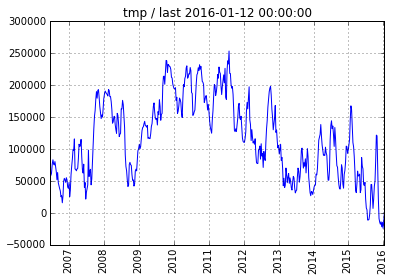

In [6]:
plot( lsdiff )

The preceding chart shows the difference between the number contracts long versus short. 
It is somewhat useful, but we would prefer a **scale-free [0,1] measure** which 
reveal position: 0 for bearish, 0.50 for neutral, and 1 for bullish. 

This will also allow us later to *combine* readings to show position in a class, 
for example, the US dollar versus various foreign currencies.

In [7]:
#  Scale-free measure from zero to 1:
z_xau = todf( longs / (longs + shorts ))

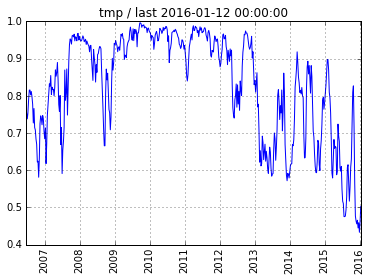

In [8]:
#  Could interpret as prob( bullish Manager ):
plot( z_xau )

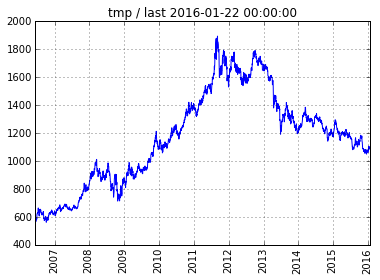

In [9]:
# How does our indicator compare to spot gold prices?
xau = get( d4xau )
plot( xau['2006-06-12':] )
# using the FRED database for Gold London PM fix.

GOLD: We can definitely see a "raging bull" in action through 2013 -- 
our position indicator approaches 1.0 frequently! Thereafter, there are 
four major efforts to re-ignite the bull market through mid-2015, 
but without much success as the price creeps downward. 

July 2016 sees a breakdown below the 0.6 positional support, 
to under the 0.5 neutral mark -- which means more shorts than longs among managers. 
The Fed raises rates on 2015-12-16 (first time in almost a decade), 
and the indicator settles down below 0.5 for the start of 2016.

## Generalization to Asset Classes

### Following function will compute position for commodities and financials:

*It returns our scale-free measure on [0,1] such that comparable contracts 
can easily be averaged, and thus interpreted.*

In [10]:
#       ? or ?? is useful to investigate source.
cotr_position??

Signature: cotr_position(futures='GC')
Source:
def cotr_position( futures='GC' ):
     '''Extract market position from CFTC Commitment of Traders Report.'''
     cotr = cotr_get( futures )
     #  Report for both futures and options requested by implicit "FO".
     #
     #  For directionality we use these categories:
     try:
          longs  = cotr['Asset Manager Longs']
          shorts = cotr['Asset Manager Shorts']
          #  "Leveraged Funds" for FINANCIALS appear short-term, whereas 
          #  "Asset Manager" takes longer term perspective.
     except:
          longs  = cotr['Money Manager Longs']
          shorts = cotr['Money Manager Shorts']
          #  "Money Manager" for COMMODITIES. 
          #  The report is structured differently than financials.
          #
     #                _Scale-free between 0 and 1 indicating bullishness.
     return tools.todf( longs / (longs + shorts ))
File:      ~/Dropbox/ipy/fecon235/lib/yi_quandl.py
Type:      function

## Precious metals

Let's first take a look at the COTR position for silver (spot symbol XAG). 
Graphically it is quite similar to gold, so we will also 
examine their statistical correlation.

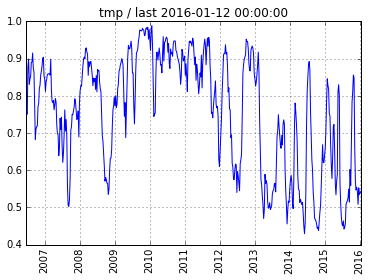

In [11]:
#  Silver position:
z_xag = cotr_position( f4xag )
plot( z_xag )

In [12]:
#  Correlation and regression:
#  stat2( z_xag['Y'], z_xau['Y'] )

COTR positions for gold and silver are correlated (approximately 77%), 
but a linear regression model is not satisfactory. This means they 
each contain some information that the other lacks. But since the 
market sentiment regarding both are similar, it is useful to 
combine their signals as precious metals.

#### TECHNIQUE: compute the mean of indicators for an asset class

We use the futures and options COTR for contracts on both gold and silver, 
then average their position indicators. We can run this procedure by 
retrieval of a variable called w4cotr_metals 
(where w4 tells us that it's weekly series). 
See the yi_quandl module for details.

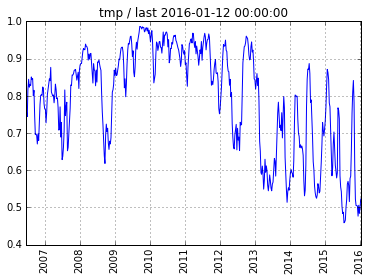

In [13]:
#  PRECIOUS METALS position:
z_metals = get( w4cotr_metals )
plot( z_metals )

Positions in the precious metals have recently exhibited 
swings characteristic of momentum trading. 
That may be also due to the fact that strategic positions 
are taken for the long-term in ETFs, for example: 
GLD in the case of gold and John Paulson, rather than 
in the futures market to avoid rollover costs and slippage. 
Counter-tactical positions may be traded against 
the ETFs in the short-term in the futures/options market, 
however, those will not be accounted as spreads in the COTR. 
Thus we must be aware of bias created by trading in related 
markets which are not under CFTC jurisdiction.

Worth noting is the August 2015 dip into net short region. 

#### TECHNIQUE: damped indicator swings can show trends in the underlying prices

We can demonstrate this by applying 
*exponential moving average*, **ema()**.

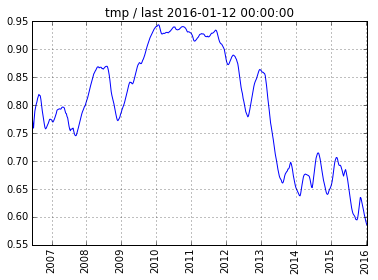

In [14]:
z_metal_ema = ema(z_metals, 0.05)
plot( z_metal_ema )

## US Dollar position

We use the futures and options COTR for contracts on both the euro and yen, 
then average their position indicators. To invert direction due to quotation style, 
we take the complement, i.e. (1-mean), so we still retain the [0,1] range. 

We can run this procedure by retrieval of a variable called *w4cotr_usd* 
(where w4 tells us that it's weekly series).

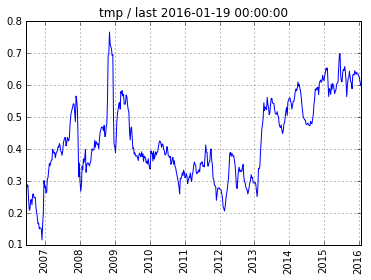

In [15]:
#  Dollar position (not price):
z_usd = get( w4cotr_usd )
plot( z_usd )

As the U.S. subprime mortgage crisis expanded worldwide, 
flight to safe USD makes a peak in our indicator exceeding 0.7, 
and thereafter, we see an orderly decline through 2013 due to 
Fed's QE quantitative easing. A bull market develops due to the 
termination of QE by the Fed, while QE is relentlessly pursued by BoJ, 
and finally the ECB activates its own QE. 
The sudden acceleration at the beginning of 2013 was a 
huge early warning sign of change in market sentiment.

Next is the dollar index (against most currencies) used by the 
Federal Reserve Bank which considers the real trade balance RTB between countries:

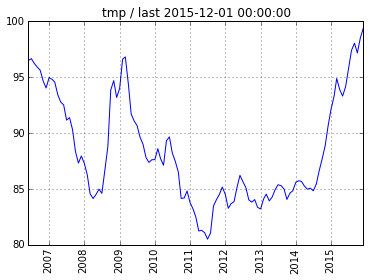

In [16]:
# Fed US Dollar index, m4 means monthly frequency:
usd = get( m4usdrtb )
plot( usd['2006-06-01':] )

## Bonds position

We use the futures and options COTR for contracts on both the 
eurodollar (strips) and 10-year Treasury bond, then average their position indicators. 
We can run this procedure by retrieval of a variable called *w4cotr_bonds* 
(where w4 tells us that it's weekly series). 

The indicator intends to show market position across the active yield curve, 
not in terms of rates, but rather prices of fixed-income instruments. 
This is useful to gauge the effects of Fed policy.

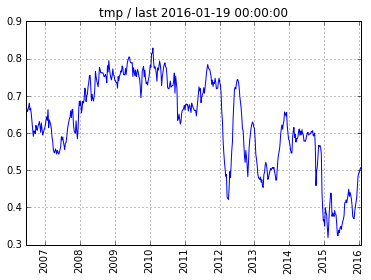

In [17]:
#  Bonds position:
z_bonds = get( w4cotr_bonds )
plot( z_bonds )

From the beginnings of the subprime mortgage crisis to 2012, 
there is a commonplacent bull market conviction that the 
Fed wants lower rates across the yield curve: bond rates fall from 5% to 1.5%. 
Thereafter, the market seeks to front-run the Fed in the event 
ZIRP Zero Interest Rate Policy is reversed, but is denied on several occassions. 

Only after 2015 does our indicator spend time below the neutral halfway mark: 
Fed has ended QE, and the market seeks to determine the time of the first rate hike 
since the Great Recession. Bottoming rates in 2012 and 2015 technically 
imply a floor around 1.8% for the 10-y Treasuries. 

Given favorable economic conditions, esp. unemployment, and the 
expected hike in September of 2015: a bear market is developing for bond valuations. 
But surprise: FOMC postpones the rate hike until 2015-12-16, 
and our indicator gets less bearish. Compared globally, US bonds yields 
are very attractive, and the USD is very strong.

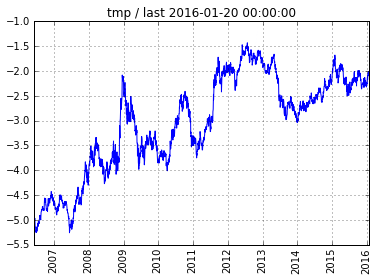

In [18]:
bondrate = get( d4bond10 )
#  10-y Treasury rate INVERTED in lieu of price:
plot( -bondrate['2006-06-01':] )

## Equities position

We use the futures and options COTR for contracts on both 
the *S&P 500 and and its e-mini version*, then average their position indicators. 
We can run this procedure by retrieval of a variable called *w4cotr_equities* 
(where w4 tells us that it's weekly series). 

It is worth noting that our position indicator is extremely bullish 
going into the Great Recession, however, even during the worst sell-offs 
in equities the indicator never goes into bear territory. 
We suspect this is because many asset managers are constrained to going net long. 

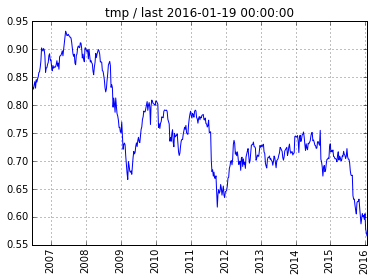

In [19]:
#  Equities position:
z_eq = get( w4cotr_equities )
plot( z_eq  )

#### TECHNIQUE: normalize market indicator

This basically translates the [0, 1] indicator into statistical terms. 
A normalized series has 0 as its mean, and its units are stated 
as standard deviations.

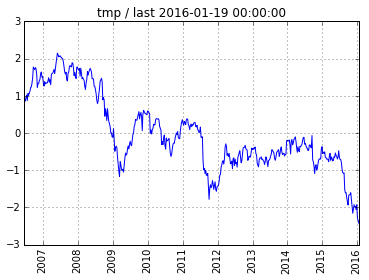

In [20]:
#  So let's normalize the equities indicator:
plot(normalize( z_eq ))

2015-08-08: Given our data, the neutral mark is around 0.77 for equities position. 
Normalized data shows we are currently over 1 standard deviation into bear territory, 
even though the market seems to make advances upward every day.

2016-01-18: Since the last Fed rate hike, equities indicator has gone under -2 std 
which is the most bearish reading thus far -- *including the Great Recession!*

 ::  S&P 500 prepend successfully goes back to 1957.


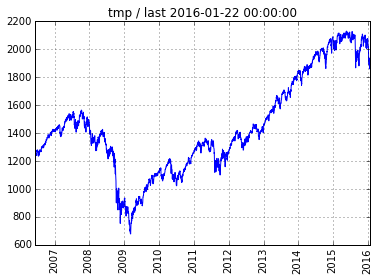

In [21]:
#  SPX price data showing the post-2009 equities bull market:
spx = get( d4spx )
plot( spx['2006-06-12':] )

## Correlation among position indicators

Note that this is quite different than the usual look at price correlations -- 
it would be more akin to seeing how informed trading correlates across asset classes.

In [22]:
# class consists of precious metals, US dollar, bonds, equities:
z_class = [ z_metals, z_usd, z_bonds, z_eq ]

z_data = paste( z_class )
z_data.columns = ['z_metals', 'z_usd', 'z_bonds', 'z_eq']
#  Created "group" dataframe z_data with above named columns.
#  Please see fecon235 module for more details.

In [23]:
stats( z_data )

         z_metals       z_usd     z_bonds        z_eq
count  500.000000  500.000000  500.000000  500.000000
mean     0.793928    0.426817    0.625487    0.760595
std      0.138830    0.126658    0.121728    0.079848
min      0.458814    0.115009    0.318970    0.572008
25%      0.690709    0.334414    0.553198    0.706483
50%      0.828849    0.397585    0.634678    0.737262
75%      0.914398    0.534973    0.735099    0.807362
max      0.986663    0.766730    0.828573    0.932568

 ::  Index on min:
z_metals   2015-07-21
z_usd      2006-11-28
z_bonds    2015-02-10
z_eq       2016-01-12
dtype: datetime64[ns]

 ::  Index on max:
z_metals   2009-09-15
z_usd      2008-11-04
z_bonds    2010-02-02
z_eq       2007-05-29
dtype: datetime64[ns]

 ::  Head:
            z_metals     z_usd   z_bonds      z_eq
Date                                              
2006-06-13  0.780357  0.281513  0.647033  0.822280
2006-06-20  0.753881  0.278856  0.666125  0.831975
2006-06-27  0.744485  0.286700  0.6581

***No strong correlations among position indicators.*** 

As expected z_metals and z_usd are negatively correlated, 
but precious metals sentiment is most correlated to bonds. 
We have closely examined the relationship between gold and interest rates 
in another notebook, and indeed, *real rates* are very significant. 
Our bond indicator, however, only relates inversely to nominal rates.

## Normalized position relative to history

We saw that our position indicator may not entirely span [0,1] as expected 
due to institutional reasons (see the equities case above). 
Thus a *position indicator reading of 0.50 does not strictly 
imply neutrality with respect to positions*.

As a remedy, we can normalize an indicator, *relative to its history*, 
and then look **comparatively across asset classes**, especially recent values.

Be aware though that as history changes, a normalized indicator 
for a given date will generally *not* stay fixed (unlike the [0,1] indicator).

In [24]:
#  Normalize indicators:
z_nor = groupfun( normalize, z_data )

In [25]:
#  Compare recent normalized indicators:
tail( z_nor, 24 )

            z_metals     z_usd   z_bonds      z_eq
Date                                              
2015-07-28 -2.397536  1.738209 -2.035013 -0.980016
2015-08-04 -2.360331  1.830168 -1.749320 -1.073864
2015-08-11 -2.108856  1.699333 -1.741836 -1.084636
2015-08-18 -1.965351  1.466904 -1.686287 -1.078823
2015-08-25 -1.664973  1.086153 -1.747761 -1.538751
2015-09-01 -1.611363  1.362334 -1.661385 -1.618071
2015-09-08 -1.688794  1.524941 -1.574311 -1.614662
2015-09-15 -2.003987  1.544770 -1.449483 -1.749689
2015-09-22 -1.555358  1.717556 -1.607234 -1.859989
2015-09-29 -1.511154  1.593426 -1.519983 -1.948061
2015-10-06 -0.998605  1.451820 -1.575402 -1.692089
2015-10-13 -0.285950  1.422868 -1.669291 -1.666700
2015-10-20  0.117193  1.280852 -1.807818 -1.669211
2015-10-27  0.342607  1.615705 -2.052048 -1.615690
2015-11-03 -0.080483  1.637337 -2.080569 -1.806226
2015-11-10 -1.297465  1.616776 -2.099652 -1.997783
2015-11-17 -1.957013  1.724855 -1.935206 -2.170417
2015-12-01 -2.080381  1.637519 

2015-12-16: This is the day of first Fed rate hike in almost a decade. 
It is very instructive to compare the readings for the previous day 
to the most recent output.

2016-01-18: Both z_metals and z_eq are two standard deviations 
into a bear market -- although their position indicators 
are in neutral territory. This is a great example of 
the utility of normalized position indicators.

*Normalized positions can useful in the identification of "overcrowded" trades.*

## Closing remarks

In general, we hope that the position indicators are *not* correlated 
too closely with the underlying prices because we are seeking information 
which is not derivable from observable prices. 
It is most interesting when market positions *diverge* 
from identified patterns in price charts.

**Normalized position indicators are useful to examine 
asset classes since the units are comparable across 
their COTR histories.**

## Appendix 1: COTR at the command line

We can algorithmically summarize this notebook for quick computation 
by the function **groupcotr()**.

In [26]:
#  Asset classes are specified as a "group" in a fecon235 dictionary:
cotr4w

{'Bonds': 'w4cotr_bonds',
 'Equities': 'w4cotr_equities',
 'Metals': 'w4cotr_metals',
 'USD': 'w4cotr_usd'}

In [27]:
#  Source code for retrieval of COTR [0,1] position indicators
#  (exactly like z_data, except column names are nicer),  
#  followed by operator to normalize the position indicators:
groupcotr??

#  This encapsulates the TECHNIQUES in this notebook,
#  including the option to apply smoothing.

#  group* functions are defined in the fecon235 module.

Signature: groupcotr(group={'Equities': 'w4cotr_equities', 'USD': 'w4cotr_usd', 'Metals': 'w4cotr_metals', 'Bonds': 'w4cotr_bonds'}, alpha=0)
Source:
def groupcotr( group=cotr4w, alpha=0 ): 
    '''Compute latest normalized CFTC COTR position indicators.
       Optionally specify alpha for Exponential Moving Average
       which is a smoothing parameter: 0 < alpha < 1 (try 0.26)
       COTR is the Commitment of Traders Report from US gov agency.
    '''
    #  For detailed derivation, see qdl-COTR-positions.ipynb
    positions = groupget( group )
    norpositions = groupfun( normalize, positions )
    #  alpha default should skip SMOOTHING operation...
    if alpha:
        return groupfun( ema, norpositions, alpha )
    else:
        return norpositions
File:      ~/Dropbox/ipy/fecon235/fecon235.py
Type:      function

In [28]:
#  MAIN in action!
norpos = groupcotr( cotr4w, alpha=0 )

In [29]:
#  Most recent results as a test exhibit:
tail( norpos, 3 )

               Bonds  Equities    Metals       USD
Date                                              
2015-12-29 -1.100589 -1.942351 -2.232522  1.600314
2016-01-05 -1.063456 -2.291344 -2.115624  1.550388
2016-01-12 -1.020780 -2.361818 -1.952927  1.449060

***Thus in a few lines of fecon235 code, we can comparatively observe how 
various asset classes are positioned in the futures and options market by informed traders.***

## Appendix 2: Joint path of Bonds and Equities

We found earlier that the linear correlation between Bonds and Equities 
is about +28% with respect to their position indicators. 
A scatter plot is useful to discern non-linearities, 
but even better would be one with a ***heat map which reveals 
their evolution chronologically.***

In [30]:
#  To broadly visualize a decade of data, 
#  we resample the weekly normalized position indicators
#  into MONTHLY frequency (median method).
norpos_month = groupfun( monthly, norpos )

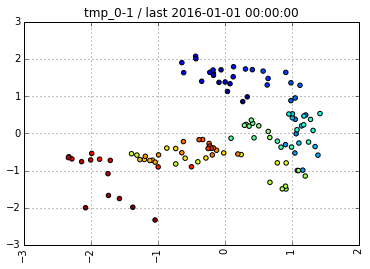

In [32]:
#  Plot from 2006 to present:
scatter( norpos_month, col=[0, 1] )

By using a color heat map, from blue to green to red, 
we can visualize the joint path of Bonds and Equities 
chronologically since 2006.

The col argument tells us that the x-axis is for Bonds, 
and the y-axis is for Equities. The *narrative* starts 
just prior to the Great Recession, when they both 
indicate bullish positions (Quandrand I in blue). 
Due to the recovery in employment, the Great Recession 
era is said to have concluded, but in 2016 
we find ourselves in joint bearish territory 
(Quandrant III in red).

From 2009 through 2015 (horizontal drift to the east from green to red), 
Equities rose in price while its normalized position indicator fluctuated around -0.5. 
During that epoch, the market increasing became more 
bearish with respect to Bonds (from +1.3 to -2.2). 
This coincides with ZIRP and numerous QE Fed policies
(Zero Interest Rate Policy and Quantitative Easing).

The most recent all-time peak for the S&P 500 is 2130.82 
on 2015-05-21. Months later, on 2015-12-16 the Fed had its 
first rate hike in almost a decade (thus terminating ZIRP). 
The scatter plot illustrates the break from the foregoing 
horizontal epoch (dark red points, Equities <= -2.0).

It is important to note that *the narrative above is 
not derived from price action, but rather the number of 
contracts positioned in the futures and options markets* 
by informed traders: Asset/Money Managers. 